In [794]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import random
from shapely.geometry import LineString,Polygon,Point, MultiPolygon, GeometryCollection, MultiLineString
import networkx as nx
from shapely.ops import split,nearest_points

import plotly.graph_objects as go
from scipy.spatial import Delaunay
%matplotlib widget

## Visualization Algorithms

Plotting delivary locations + obstacles

def initial_plot(delivary_locations, obstacles, dp=None, route = None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each building
    for building in obstacles.values():
        x = [point[0] for point in building]
        y = [point[1] for point in building]
        z = [point[2] for point in building]
    
        # Plot the bottom face
        ax.plot(x, y, zs=0, zdir='z', color='black')

        # Plot the top face
        ax.plot(x, y, zs=max(z), zdir='z', color='black')

        # Plot the walls
        for i in range(len(x)):
            ax.plot([x[i], x[i]], [y[i], y[i]], [0, z[i]], color='black')

        # Fill the building's faces
        verts_bottom = list(zip(x, y, [0] * len(x)))
        verts_top = list(zip(x, y, z))
    
        # Add bottom face
        ax.add_collection3d(Poly3DCollection([verts_bottom], facecolors='red', edgecolors='black', alpha=0.9))
    
        # Add top face
        ax.add_collection3d(Poly3DCollection([verts_top], facecolors='red', edgecolors='black', alpha=0.9))

        # Add side faces
        for i in range(len(x) - 1):
            verts_side = [
                [x[i], y[i], 0],
                [x[i+1], y[i+1], 0],
                [x[i+1], y[i+1], z[i+1]],
                [x[i], y[i], z[i]]
            ]
            ax.add_collection3d(Poly3DCollection([verts_side], facecolors='red', edgecolors='black', alpha=0.9))

        # Add the last side face connecting the last and first points
        verts_side = [
            [x[-1], y[-1], 0],
            [x[0], y[0], 0],
            [x[0], y[0], z[0]],
            [x[-1], y[-1], z[-1]]
        ]
        ax.add_collection3d(Poly3DCollection([verts_side], facecolors='red', edgecolors='gray', alpha=0.9))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height')



    # delivary points
    loc_x = [i for i,j,k in delivary_locations]
    loc_y = [j for i,j,k in delivary_locations]
    loc_z = [k for i,j,k in delivary_locations]

    ax.scatter(loc_x,loc_y,loc_z, color="blue")

    # plot dp
    if dp != None:
        ax.scatter(dp[0],dp[1],dp[2], color="orange")

    # ploting route
    if route != None:
        x_axis = [i for i,j,k in route]
        y_axis = [j for i,j,k in route]
        z_axis = [k for i,j,k in route]

        ax.plot(x_axis, y_axis, z_axis ,c="gray")

    # Set the viewing angle
    ax.view_init(elev = 92, azim=60)

    plt.show()


Plotting dp

In [795]:
def triangulate_polygon(x, y):
    points2D = np.vstack([x, y]).T
    tri = Delaunay(points2D)
    return tri.simplices

def initial_plot(delivary_locations, obstacles, dp=None, route=None):
    fig = go.Figure()

    # Plot each building
    for building in obstacles.values():
        x = [point[0] for point in building]
        y = [point[1] for point in building]
        z = [point[2] for point in building]

        # Triangulate top and bottom faces
        if len(x) > 2:  # Need at least 3 points to form a polygon
            triangles = triangulate_polygon(x, y)
        else:
            triangles = [[0, 1, 2]]

        # Bottom face
        # fig.add_trace(go.Mesh3d(
        #     x=x,
        #     y=y,
        #     z=[0] * len(x),
        #     i=triangles[:, 0],
        #     j=triangles[:, 1],
        #     k=triangles[:, 2],
        #     color='red',
        #     opacity=0.50
        # ))

        # Top face
        # fig.add_trace(go.Mesh3d(
        #     x=x,
        #     y=y,
        #     z=z,
        #     i=triangles[:, 0],
        #     j=triangles[:, 1],
        #     k=triangles[:, 2],
        #     color='red',
        #     opacity=0.50
        # ))

        # Side faces
        for i in range(len(x)):
            j = (i + 1) % len(x)
            fig.add_trace(go.Mesh3d(
                x=[x[i], x[j], x[j], x[i]],
                y=[y[i], y[j], y[j], y[i]],
                z=[0, 0, z[j], z[i]],
                i=[0, 0],
                j=[1, 2],
                k=[2, 3],
                color='red',
                opacity=0.50
            ))

        # Add borders for the top face
        fig.add_trace(go.Scatter3d(
            x=x + [x[0]],
            y=y + [y[0]],
            z=z + [z[0]],
            mode='lines',
            line=dict(color='black', width=3)
        ))

        # Add borders for the bottom face
        fig.add_trace(go.Scatter3d(
            x=x + [x[0]],
            y=y + [y[0]],
            z=[0] * (len(x) + 1),
            mode='lines',
            line=dict(color='black', width=3)
        ))

        # Add borders for the sides
        for i in range(len(x)):
            j = (i + 1) % len(x)
            fig.add_trace(go.Scatter3d(
                x=[x[i], x[i], x[j], x[j], x[i]],
                y=[y[i], y[i], y[j], y[j], y[i]],
                z=[0, z[i], z[j], 0, 0],
                mode='lines',
                line=dict(color='black', width=3)
            ))

    # Delivery points
    loc_x = [i for i, j, k in delivary_locations]
    loc_y = [j for i, j, k in delivary_locations]
    loc_z = [k for i, j, k in delivary_locations]

    fig.add_trace(go.Scatter3d(
        x=loc_x,
        y=loc_y,
        z=loc_z,
        mode='markers',
        marker=dict(size=5, color='blue')
    ))

    # Plot dp
    if dp:
        fig.add_trace(go.Scatter3d(
            x=[dp[0]],
            y=[dp[1]],
            z=[dp[2]],
            mode='markers',
            marker=dict(size=8, color='orange')
        ))

    # Plotting route
    if route:
        x_axis = [i for i, j, k in route]
        y_axis = [j for i, j, k in route]
        z_axis = [k for i, j, k in route]

        fig.add_trace(go.Scatter3d(
            x=x_axis,
            y=y_axis,
            z=z_axis,
            mode='lines',
            line=dict(color='gray', width=5)
        ))

    # Update layout for better view
    fig.update_layout(
        width = 800,
        height = 800,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Height',
            aspectmode='cube'
    ))

    # Show plot
    fig.show()

Plotting route

In [796]:
def visualize_graph(G, path=None):
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract node positions for plotting
    node_positions = {node: (node[0], node[1], node[2]) for node in G.nodes()}
    
    # Plot nodes
    xs, ys, zs = zip(*node_positions.values())
    ax.scatter(xs, ys, zs, c='b', marker='o')
    
    # Plot edges
    for edge in G.edges():
        x_vals = [node_positions[edge[0]][0], node_positions[edge[1]][0]]
        y_vals = [node_positions[edge[0]][1], node_positions[edge[1]][1]]
        z_vals = [node_positions[edge[0]][2], node_positions[edge[1]][2]]
        ax.plot(x_vals, y_vals, z_vals, c='k')
    
    # Highlight the shortest path if provided
    if path:
        path_x = [node[0] for node in path]
        path_y = [node[1] for node in path]
        path_z = [node[2] for node in path]
        ax.plot(path_x, path_y, path_z, c='r', linewidth=2)
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    plt.show()

## Obstacle Modifications

In [797]:
def create_polygon(points, height = 0):
    coords = []

    for pt in points:
        coords.append([pt[0],pt[1],height])

    obs_polygon = Polygon(coords)
    return obs_polygon

In [798]:
def build_3d_polygon(coords):
    # Add z coordinate to each point
    polygon_coords = [(x, y, z) for x, y, z in coords]
    
    # Create the top and bottom polygons
    top_polygon = Polygon(polygon_coords)
    bottom_polygon = Polygon([(x, y, 0) for x, y, _ in polygon_coords])
    
    # Create the side polygons
    side_polygons = []
    for i in range(len(coords) - 1):
        side_polygon_coords = [
            polygon_coords[i],
            polygon_coords[i+1],
            (coords[i+1][0], coords[i+1][1], 0),
            (coords[i][0], coords[i][1], 0),
            polygon_coords[i]
        ]
        side_polygon = Polygon(side_polygon_coords)
        side_polygons.append(side_polygon)
    
    # Combine all polygons into a MultiPolygon
    all_polygons = [top_polygon, bottom_polygon] + side_polygons
    return MultiPolygon(all_polygons)

In [799]:
def line_intersect(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [800]:
def get_intersection_coordinate(intersection):
    points = []
    if intersection.geom_type == "LineString" or intersection.geom_type == "Point":
        coord = list(intersection.coords)
        for cord in coord:
            points.append(cord)
    elif intersection.geom_type == "GeometryCollection" or intersection.geom_type == "MultiLineString":
        for subgeom in intersection.geoms:
            if subgeom.geom_type == 'Point' or subgeom.geom_type == 'LineString':
                coord = list(subgeom.coords)
                for cord in coord:
                    points.append(cord)
    return points

In [801]:
def get_z_coordinate(intersection):
    z_points = []
    if intersection.geom_type == "LineString" or intersection.geom_type == "Point":
        coord = list(intersection.coords)
        for cord in coord:
            z_points.append(cord[2])
    elif intersection.geom_type == "GeometryCollection" or intersection.geom_type == "MultiLineString":
        for subgeom in intersection.geoms:
            if subgeom.geom_type == 'Point' or subgeom.geom_type == 'LineString':
                coord = list(subgeom.coords)
                for cord in coord:
                    z_points.append(cord[2])
    return z_points


In [802]:
def has_2d_intersection(line, polygon):
    intersect = line_intersect(line, polygon)
    if not intersect:
        return False

    intersection = line.intersection(polygon)
    # Check if z-coordinate of intersection is within tolerance of both line and polygon
    z_line_1, z_line_2 = line.coords[0][2], line.coords[1][2]
    z_intersection = max(z for x,y,z in list(polygon.exterior.coords))
    result = (z_intersection >= z_line_1) or (z_intersection >= z_line_2)
    
    return result if not result else intersection

## Delivery Points modification

In [803]:
def create_delivary(x,y,n, seed_value = None):
    if seed_value != None:
        random.seed(seed_value)

    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for _ in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append(tuple([x_loc, y_loc, 0]))

    return loc

In [804]:
def remove_obstacle(delivary_loc, obstacles):
    obstacle_polygon = {obs_id : create_polygon(obs, 0) for obs_id, obs in obstacles.items()}
    delivary_point = [Point([a,b,c]) for a,b,c in delivary_loc]
    final_point = []
    
    for point in delivary_point:
        flag = True
        for obs_id, obs in obstacle_polygon.items():
            if (point.intersects(obs)):
                flag = False
                break
        if flag:
            final_point.append(tuple([point.x, point.y, 0]))
    return final_point

In [805]:
def calculate_dp(delivary_loc):
    x = [i for i,j,k in delivary_loc]
    y = [j for i,j,k in delivary_loc]

    dp = tuple([np.mean(x), np.mean(y), 0])

    return dp

#### routing modifications

In [806]:
def create_obstacle_free_route(delivary_loc, dp, height):
    route = []
    for loc in delivary_loc:
        route.append(dp)
        route.append(tuple([dp[0],dp[1],height]))
        route.append(tuple([loc[0],loc[1],height]))
        route.append(loc)
        route.append(tuple([loc[0],loc[1],height]))
        route.append(tuple([dp[0],dp[1],height]))

    route.append(dp)

    return route

In [807]:
def euclidean_distance(pt_1, pt_2):
    distance = np.sqrt((pt_2[0]-pt_1[0])**2 + (pt_2[1]-pt_1[1])**2 + (pt_2[2]-pt_1[2])**2)

    return distance

In [808]:
def calculate_route_distance(route) :
    distance = 0
    for i in range(len(route)-1):
        distance += euclidean_distance(route[i],route[i+1])

    return distance

In [809]:
def create_shortest_dijkstra_path(source, dest, obstacles, drone_height):

    # creating obstacle polygons
    obstacle_polygon = {ob_id : create_polygon(obs, height=obs[0][2]) for ob_id, obs in obstacles.items()}
    const = 0.005

    G = nx.Graph()

    # connecting nodes
    G.add_node(tuple([source[0], source[1], drone_height]))

    for i in dest:
        G.add_node(tuple([i[0], i[1], drone_height]))

    # if height of an obstacle is less than drone height then ignore that obstacle
    for obs_id, obstacle in obstacles.items():
        if max([z for x,y,z in obstacle]) > drone_height:
            for i in obstacle:
                G.add_node(tuple([i[0],i[1],drone_height]))

    for loc in dest:
        line = LineString([[source[0], source[1], drone_height],[loc[0],loc[1],drone_height]])
        for obs_id, obs in obstacle_polygon.items():
            intersection = has_2d_intersection(line,obs)
            if intersection:
                collision_points = get_intersection_coordinate(intersection)
                z_axis = max([z for x,y,z in obstacles[obs_id]]) + const
                
                for i in range (len(collision_points)):
                    if i == 0:
                        G.add_node(tuple([collision_points[i][0] - const, collision_points[i][1], z_axis]))
                    elif i == len(collision_points) - 1:
                        G.add_node(tuple([collision_points[i][0] + const, collision_points[i][1], z_axis]))
                    else:
                        G.add_node(tuple([collision_points[i][0], collision_points[i][1], z_axis]))

    nodes = list(G.nodes())

    # connecting edges
    for i in range(0,len(nodes)-1):
        for j in range(i+1,len(nodes)):
            intersect = False
            for obs_id, obstacle in obstacle_polygon.items():
                if has_2d_intersection(LineString([nodes[i],nodes[j]]),obstacle):
                    intersect = True
                    break
            if not intersect:
                G.add_edge(nodes[i],nodes[j], weight = euclidean_distance(nodes[i],nodes[j]))

    dijkstra_paths = nx.all_pairs_dijkstra(G)
    paths = []
    
    # creating the path
    for target_node, (distances, path) in dijkstra_paths:
        if target_node == tuple([source[0], source[1], drone_height]):
            for loc_node in dest:
                cur_path = path[tuple([loc_node[0],loc_node[1], drone_height])]
                route = cur_path.copy()
                route.insert(0, tuple([source[0], source[1], 0]))
                route.append(tuple([route[-1][0], route[-1][1], 0]))
                route.append(tuple([route[-1][0], route[-1][1], drone_height]))

                for i in range(len(cur_path)-2,0,-1):
                    route.append(cur_path[i])
                route.append(tuple([source[0], source[1], drone_height]))
                route.append(source)
                paths.extend(route)

    visualize_graph(G, paths)

    return paths, "pass"

In [810]:
def route_refinement_2D(route, dp, drone_height):
    final_route = []

    final_route.append(dp)
    for i in route:
        final_route.append(tuple([i[0], i[1], drone_height]))
    final_route.append(dp)

    return final_route

## Main

In [811]:
# pre-assumptions
x = [22.21, 88.45]
y = [34.45, 98.67]
drone_height = 8
seed_value = 11

# creating obstacles
obstacles = {
    0 : [[27.81, 90.75,3],[28.74, 91.42, 3],[27.80, 93.15, 3], [26.81, 92.53,3], [27.81, 90.75,3]],
    1 : [[23.11, 91.25,3], [24.81, 92.40,3], [24.21, 93.45, 3], [22.51, 92.35, 3],[23.11, 91.25, 3]],
    2 : [[24.55, 88.60,10],[25.96, 89.55,10],[25.01, 91.35, 10],[23.61, 90.32, 10],[24.55, 88.60, 10]],
    3 : [[25.60, 88.45,10], [27.42, 88.45,10],[26.92, 89.35,10],[25.60, 88.45,10]],
    4 : [[27.61, 88.45,10], [28.81, 88.45,10],[29.12, 88.66,10],[28.02, 90.45,10],[26.90, 89.57,10],[27.61, 88.45,10]],
    5 : [[25.33, 92.62,10], [25.86, 92.95,10], [25.21, 94.15,10], [24.69, 93.78,10], [25.33, 92.63,10]],
    6 : [[26.11, 93.05,3], [26.62, 93.35,3], [25.81, 94.65,3], [25.39, 94.35,3], [26.11, 93.05,3]],
    7 : [[26.72, 93.65,10], [27.32, 94.05,10], [26.69, 95.18,10], [26.10, 94.83,10], [26.72, 93.65,10]],
    8 : [[25.81, 95.40,10],[26.29, 95.70,10],[26.01, 96.20,10],[26.25, 96.37,10],[25.93, 96.94,10],[25.80, 96.84,10], [25.69, 97.01,10],[25.11, 96.65,10],[25.81, 95.40,10]],
    9 : [[23.90, 94.15,3], [24.91, 94.81,3], [24.48, 95.57,3],[23.48, 94.95,3],[23.90, 94.15,3]],
    10 : [[23.71, 98.67,10], [23.91, 98.26,10], [24.41, 98.67,10],[23.71, 98.67,10]],
    11 : [[31.81, 90.35,10], [32.51, 90.85,10], [32.21, 91.55,10], [32.03, 91.85,10], [34.31, 93.45,10], [32.69, 96.27,10],[30.99, 95.15,10], [32.21, 92.93,10],[30.89, 91.97,10],[31.81, 90.35,10]],
    12 : [[30.21, 96.00,10],[31.85, 97.11,10], [31.02, 98.55,10], [30.50, 98.26,10], [30.31, 98.53,10], [30.51, 98.67,10],[27.81, 98.67,10], [27.21, 98.28,10], [27.73, 97.43,10],[28.95, 98.25,10],[30.21, 96.00,10]]
}

In [812]:
# creating delivary locations

n = 50

# answers
optimal_dp = []
optimal_route = []

delivary_loc = create_delivary(x,y,n, seed_value=seed_value)

delivary_loc = remove_obstacle(delivary_loc, obstacles)

print(len(delivary_loc))

extra_loc = []

while (len(extra_loc) != n - len(delivary_loc)):
    extra_loc = create_delivary(x,y,n - len(delivary_loc))
    extra_loc = remove_obstacle(extra_loc, obstacles)
delivary_loc.extend(extra_loc)

print(len(delivary_loc))

34
50


In [813]:
initial_plot(delivary_locations=delivary_loc, obstacles=obstacles)

In [814]:
# creating initial dp

initial_dp = calculate_dp(delivary_loc)

initial_dp

(27.55470577587296, 93.92084405438013, 0)

In [815]:
# delivary_loc = [[34.21685, 92.38249, 0]]
# initial_dp = [27.55470577587296, 93.92084405438013, 0]

In [816]:
# plot dp

initial_plot(delivary_locations=delivary_loc, obstacles=obstacles, dp=initial_dp)

#### Obstacle free route

In [817]:
# creating obstacle free route
route_1 = create_obstacle_free_route(delivary_loc, initial_dp, drone_height)
route_1

[(27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 8),
 (27.747125734960182, 94.17087378574267, 8),
 (27.747125734960182, 94.17087378574267, 0),
 (27.747125734960182, 94.17087378574267, 8),
 (27.55470577587296, 93.92084405438013, 8),
 (27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 8),
 (28.4259771822822, 94.45307295084595, 8),
 (28.4259771822822, 94.45307295084595, 0),
 (28.4259771822822, 94.45307295084595, 8),
 (27.55470577587296, 93.92084405438013, 8),
 (27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 8),
 (24.470242608783693, 93.68170629100726, 8),
 (24.470242608783693, 93.68170629100726, 0),
 (24.470242608783693, 93.68170629100726, 8),
 (27.55470577587296, 93.92084405438013, 8),
 (27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 8),
 (23.319807378900116, 96.72456714123255, 8),
 (23.319807378900116, 96.72456714123255, 0),
 (23.319807378900116, 96.72

In [818]:
# ploting th route

initial_plot(delivary_locations=delivary_loc, obstacles=obstacles, dp=initial_dp, route = route_1)

In [819]:
# calculate distance of the obstacle free route
distance_1 = calculate_route_distance(route_1)

distance_1

2060.6546712845648

#### Obstacle avoidance (3D)

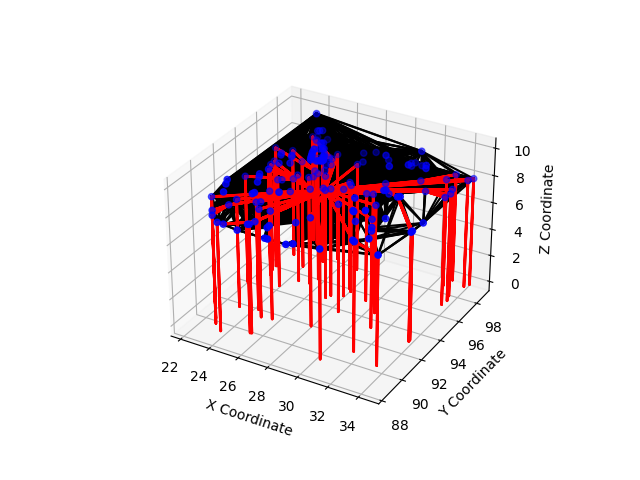

[(27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 8),
 (27.747125734960182, 94.17087378574267, 8),
 (27.747125734960182, 94.17087378574267, 0),
 (27.747125734960182, 94.17087378574267, 8),
 (27.55470577587296, 93.92084405438013, 8),
 (27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 8),
 (28.4259771822822, 94.45307295084595, 8),
 (28.4259771822822, 94.45307295084595, 0),
 (28.4259771822822, 94.45307295084595, 8),
 (27.55470577587296, 93.92084405438013, 8),
 (27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 0),
 (27.55470577587296, 93.92084405438013, 8),
 (26.72, 93.65, 8),
 (25.21, 94.15, 8),
 (24.470242608783693, 93.68170629100726, 8),
 (24.470242608783693, 93.68170629100726, 0),
 (24.470242608783693, 93.68170629100726, 8),
 (25.21, 94.15, 8),
 (26.72, 93.65, 8),
 (27.55470577587296, 93.92084405438013, 8),
 (27.55470577587296, 93.9208440543801

In [820]:
# create obstacle avoided route

route_2, msg = create_shortest_dijkstra_path(initial_dp, delivary_loc.copy(), obstacles, drone_height)
route_2

In [821]:
# ploting th route

initial_plot(delivary_locations=delivary_loc, obstacles=obstacles, dp=initial_dp, route = route_2.copy())

<font color="orange">Test</font>

In [822]:
def build_3d_polygon(coords):
    # Add z coordinate to each point
    polygon_coords = [(x, y, z) for x, y, z in coords]
    
    # Create the top and bottom polygons
    top_polygon = Polygon(polygon_coords)
    bottom_polygon = Polygon([(x, y, 0) for x, y, _ in polygon_coords])
    
    # Create the side polygons
    side_polygons = []
    for i in range(len(coords) - 1):
        side_polygon_coords = [
            polygon_coords[i],
            polygon_coords[i+1],
            (coords[i+1][0], coords[i+1][1], 0),
            (coords[i][0], coords[i][1], 0),
            polygon_coords[i]
        ]
        side_polygon = Polygon(side_polygon_coords)
        side_polygons.append(side_polygon)
    
    # Combine all polygons into a MultiPolygon
    all_polygons = [top_polygon, bottom_polygon] + side_polygons
    return MultiPolygon(all_polygons)

box = build_3d_polygon([[31.81, 90.35,10], [32.51, 90.85,10], [32.21, 91.55,10], [32.03, 91.85,10], [34.31, 93.45,10], [32.69, 96.27,10],[30.99, 95.15,10], [32.21, 92.93,10],[30.89, 91.97,10],[31.81, 90.35,10]])

line = LineString([(31.81, 90.35,10), (32.69, 96.27,10)])

print(line.intersection(box))

print(box)

MULTILINESTRING Z ((31.81 90.35 10, 32.03238267148014 91.84602888086643 9.933814681107206), (32.033319216516674 91.85232927474854 10, 32.191515151515155 92.9165564738292 5), (32.1970235396687 92.95361290322582 9.946817785527454, 32.69 96.27 10))
MULTIPOLYGON Z (((31.81 90.35 10, 32.51 90.85 10, 32.21 91.55 10, 32.03 91.85 10, 34.31 93.45 10, 32.69 96.27 10, 30.99 95.15 10, 32.21 92.93 10, 30.89 91.97 10, 31.81 90.35 10)), ((31.81 90.35 0, 32.51 90.85 0, 32.21 91.55 0, 32.03 91.85 0, 34.31 93.45 0, 32.69 96.27 0, 30.99 95.15 0, 32.21 92.93 0, 30.89 91.97 0, 31.81 90.35 0)), ((31.81 90.35 10, 32.51 90.85 10, 32.51 90.85 0, 31.81 90.35 0, 31.81 90.35 10)), ((32.51 90.85 10, 32.21 91.55 10, 32.21 91.55 0, 32.51 90.85 0, 32.51 90.85 10)), ((32.21 91.55 10, 32.03 91.85 10, 32.03 91.85 0, 32.21 91.55 0, 32.21 91.55 10)), ((32.03 91.85 10, 34.31 93.45 10, 34.31 93.45 0, 32.03 91.85 0, 32.03 91.85 10)), ((34.31 93.45 10, 32.69 96.27 10, 32.69 96.27 0, 34.31 93.45 0, 34.31 93.45 10)), ((32.69 96

In [823]:
# sample = Polygon([[4, 4, 10],[8, 4, 10],[8, 8, 10], [4, 8,10], [4, 4,10]])
# line_1 = LineString([[4, 4, 6],[8, 8, 6]])
# line_2 = LineString([[4, 6, 10.005],[9, 6, 6]])

sample = Polygon([[31.81, 90.35,10], [32.51, 90.85,10], [32.21, 91.55,10], [32.03, 91.85,10], [34.31, 93.45,10], [32.69, 96.27,10],[30.99, 95.15,10], [32.21, 92.93,10],[30.89, 91.97,10],[31.81, 90.35,10]])
line_1 = LineString([(27.55470577587296, 93.92084405438013, 8), (34.21685, 92.38249, 8)])
line_2 = LineString([(32.12222051006772 - 0.005, 92.86616037095834, 10.005) ,(33.14235647037094 + 0.005, 92.63060103183926, 10.005)])
line_3 = LineString([(27.55470577587296, 93.92084405438013, 8.0), (33.14235647037094 + 0.005, 92.63560103183926, 10.005)])

print(line_1)
print(sample)

print('-'*50)
# true
print(line_1.intersection(sample))
print(line_intersect(line_1, sample))
print(has_2d_intersection(line_1, sample))

print('-'*50)
# false
print(line_2.intersection(sample))
print(line_intersect(line_2, sample))
print(has_2d_intersection(line_2, sample))

print('-'*50)
# false
print(line_3.intersection(sample))
print(line_intersect(line_3, sample))
print(has_2d_intersection(line_3, sample))

LINESTRING Z (27.55470577587296 93.92084405438013 8, 34.21685 92.38249 8)
POLYGON Z ((31.81 90.35 10, 32.51 90.85 10, 32.21 91.55 10, 32.03 91.85 10, 34.31 93.45 10, 32.69 96.27 10, 30.99 95.15 10, 32.21 92.93 10, 30.89 91.97 10, 31.81 90.35 10))
--------------------------------------------------
LINESTRING Z (32.12222051006772 92.86616037095834 9, 33.14235647037094 92.63060103183926 9)
True
LINESTRING Z (32.12222051006772 92.86616037095834 9, 33.14235647037094 92.63060103183926 9)
--------------------------------------------------
LINESTRING Z (32.12102447276076 92.8652905256442 10.002500000000001, 33.14358531093158 92.63146337609233 10.002500000000001)
True
False
--------------------------------------------------
LINESTRING Z (32.12747232394819 92.86997987196233 9.81968260040902, 33.147356470370944 92.63560103183926 10.005)
False
False


In [824]:
list(line_1.coords)[0]

(27.55470577587296, 93.92084405438013, 8.0)

In [825]:
max(z for x,y,z in list(sample.exterior.coords))

10.0

In [826]:
point = Point([28.74, 91.42, 10])
# geom = GeometryCollection([line_1, point])
geom = MultiLineString([[[31.639749840946074, 96.96769653868911, 5], [29.431190136335122, 97.39073189940157, 5]],
                        [[28.06181925411113, 97.65302605604191, 5], [27.531407050059133, 97.7546230912495, 5]]])
print(geom)
all_points = []

# Iterate through geometries in the collection
for subgeom in geom.geoms:
  # Check if the subgeometry is a Point type
  if subgeom.geom_type == 'Point' or subgeom.geom_type == 'LineString':
    coord = list(subgeom.coords)
    for cord in coord:
      all_points.append(cord[2])

# Print the list of points
print(all_points)

MULTILINESTRING Z ((31.639749840946074 96.96769653868911 5, 29.431190136335122 97.39073189940157 5), (28.06181925411113 97.65302605604191 5, 27.531407050059133 97.7546230912495 5))
[5.0, 5.0, 5.0, 5.0]


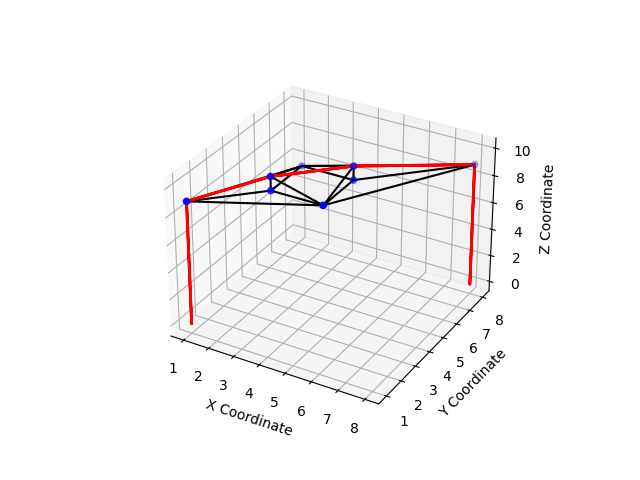

[(1, 1, 0),
 (1, 1, 9),
 (2.995, 3.0, 10.005),
 (5.005, 5.0, 10.005),
 (8, 8, 9),
 (8, 8, 0),
 (8, 8, 9),
 (5.005, 5.0, 10.005),
 (2.995, 3.0, 10.005),
 (1, 1, 9),
 [1, 1, 0]]

In [827]:
source = [1,1,0]
dest = [[8,8,0]]
drone_height = 9

obstacles_2 = {0:[[3,3,10],[5,3,10],[5,5,10],[3,5,10],[3,3,10]]}

route, msg = create_shortest_dijkstra_path(source, dest, obstacles_2, drone_height)

route

In [828]:
initial_plot(delivary_locations=dest, obstacles=obstacles_2, dp=source, route = route.copy())